## Подготовка данных для обучение (формирование выборок)

Будем брать случайным образом num_images картинок из датасета, и обработав albumentations, записывать в виде массива на диск. Таких выборок планируется N.

Часть картинок будет сразу сохранена для тестов и в выборки не попадет.

Если всего в датасете img_names_for_np картинок,
то каждая картинка будет попадать в конкретную выборку с вероятностью num_images/img_names_for_np.

Можно ожидать что каждая картинка (с учетом аугментации)
попадет в выборки num_images/img_names_for_np * N раз.

### Импорт библиотек

In [1]:
!python --version

Python 3.9.13


In [2]:
import numpy as np
import random
import os
import time
# from operator import itemgetter

import cv2 as cv
import matplotlib.pyplot as plt 
# import PIL
# from PIL import Image

import albumentations as A

In [3]:
SEED = 1111
random.seed(SEED)
np.random.seed(SEED)

# import tensorflow as tf
# tf.random.set_seed(SEED)

### Анализ данных

In [4]:
!ls /HDD/my_data/NIIAS-RZD/train

images	mask


In [5]:
# Пути к данным
dataset_path = "/HDD/my_data/NIIAS-RZD/train"
images_path = "/HDD/my_data/NIIAS-RZD/train/images"
anns_path = "/HDD/my_data/NIIAS-RZD/train/mask"
test_path = "/HDD/my_data/NIIAS-RZD/test"

In [6]:
# Создадим списки файлов с путями к ним
img_names= [ os.path.join(images_path, file_name) for file_name in os.listdir(images_path)]
ann_names = [ os.path.join(anns_path, file_name) for file_name in os.listdir(anns_path)]
test_names= [ os.path.join(test_path, file_name) for file_name in os.listdir(test_path)]

==================================================================================

In [116]:
# Проверим что каждой картинке соответствует ее размеченный вариант
error_count = 0
cur_time = time.time()
for file_name in os.listdir(images_path):
    if  not file_name in os.listdir(anns_path):
        print("Не нашли аннотацию для файла {}".format(file_name))
        error_count += 1
        
if error_count == 0:
    print("Все аннотации на месте")
else:
    print("Всего не нашли аннотаций для {} файлов".format(error_count))   
print("Время выполнения: ", round(time.time() - cur_time, 2), 'c', sep='')

Все аннотации на месте
Время выполнения: 36.18c


In [118]:
# Посмотрим каких размеров картинки в датасете
dict = {}
cur_time = time.time()
for file_name  in img_names:
    img = cv.imread(file_name)
    if str(img.shape) in dict.keys():
        dict[str(img.shape)] += 1
    else:
        dict[str(img.shape)] = 1
    
print("Имеем {} картинок".format(len(img_names)))
print("Встречаются размеры: {}".format(dict))
print("Время выполнения: ", round(time.time() - cur_time, 2), 'c', sep='')

Имеем 8203 картинок
Встречаются размеры: {'(1512, 2688, 3)': 5582, '(1080, 1920, 3)': 2604, '(2160, 3840, 3)': 17}
Время выполнения: 976.89c


In [119]:
# Посмотрим каких размеров картинки для теста
dict = {}
cur_time = time.time()
for file_name  in test_names:
    img = cv.imread(file_name)
    if str(img.shape) in dict.keys():
        dict[str(img.shape)] += 1
    else:
        dict[str(img.shape)] = 1
    
print("Имеем {} тестовых картинок".format(len(test_names)))
print("Встречаются размеры: {}".format(dict))
print("Время выполнения: ", round(time.time() - cur_time, 2), 'c', sep='')

Имеем 1000 тестовых картинок
Встречаются размеры: {'(2160, 3840, 3)': 526, '(1512, 2688, 3)': 474}
Время выполнения: 215.93c


In [120]:
# Соберем информацию о классах разметки сегментации
ann_set = np.array([])
cur_time = time.time()
for file_name  in ann_names:
    ann = cv.imread(file_name)
    curr_set = np.unique(ann)
    ann_set = np.union1d(ann_set, curr_set)
    
print("Получили классы разметки: {}".format(ann_set))
print("Время выполнения: ", round(time.time() - cur_time, 2), 'c', sep='')

Получили классы разметки: [ 0.  6.  7. 10.]
Время выполнения: 1743.45c


**0 фон**

**6 прочие пути**
 
**7 главный путь**

**10 подвижной состав**

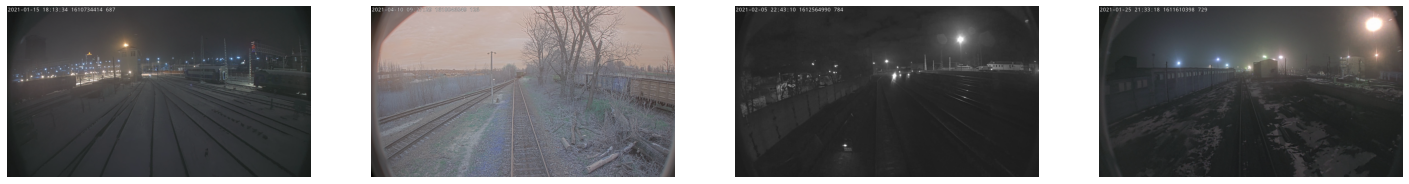

In [7]:
# Посмотрим n оригинальных случайных картинок из тренировочной выборки
n = 4
fig, axs = plt.subplots(1, n, figsize=(25, 10))  

n_files = random.choices(img_names, k=n) 

for i,file in enumerate(n_files):                               
  image = cv.imread(file)
  axs[i].axis('off')
  axs[i].imshow(image)             

plt.show()   

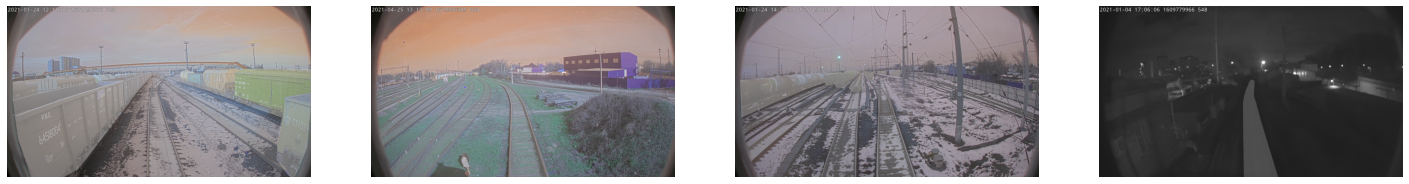

In [9]:
# Посмотрим n оригинальных случайных картинок из тренировочной выборки c наложением маски
# (маску визуалилируем с прозрачностью)
n = 4
fig, axs = plt.subplots(1, n, figsize=(25, 10))  

n_files = random.choices(img_names, k=n) 

for i,file in enumerate(n_files):                               
  image = cv.imread(file)
  ann = cv.imread(os.path.join(anns_path, os.path.basename(file)), 0) * 25
    
  image[:, :, 0] = np.where(ann == 0, image[:, :, 0], image[:, :, 0] * 0.7 + ann*0.3)
  image[:, :, 1] = np.where(ann == 0, image[:, :, 1], image[:, :, 1] * 0.7 + ann*0.3)
  image[:, :, 2] = np.where(ann == 0, image[:, :, 2], image[:, :, 2] * 0.7 + ann*0.3)

  
  axs[i].axis('off')
  axs[i].imshow(image)             

plt.show()   

### Функции

In [16]:
# Функция преобразования аннотации в one hot encoding
# classes = [0, 6, 7, 10]
def mask_to_ohe(ann_image, classes=[0, 6, 7, 10]):
    
    ones = np.ones((ann_image.shape[0], ann_image.shape[1], len(classes)),dtype = np.uint8)
    zeros = np.zeros((ann_image.shape[0], ann_image.shape[1], len(classes)),dtype = np.uint8)
    
    result = zeros.copy()
    
    result[:, :, 0] = np.where(ann_image == 0, ones[:, :, 0], zeros[:, :, 0])
    result[:, :, 1] = np.where(ann_image == 6, ones[:, :, 1], zeros[:, :, 1])
    result[:, :, 2] = np.where(ann_image == 7, ones[:, :, 2], zeros[:, :, 2])
    result[:, :, 3] = np.where(ann_image == 10, ones[:, :, 3], zeros[:, :, 3])
    
    return result

In [11]:
# Функция преобразования аннотации из ohe в классы
def ohe_to_mask(ann_ohe, classes=[0, 6, 7, 10]):
    
    ones = np.ones((ann_ohe.shape[0], ann_ohe.shape[1]),dtype = np.uint8)
    zeros = np.zeros((ann_ohe.shape[0], ann_ohe.shape[1]),dtype = np.uint8)
    
    result = zeros.copy()    
    
    result = np.where(ann_ohe[:,:,0] == 1, ones * 0, result)
    result = np.where(ann_ohe[:,:,1] == 1, ones * 6, result)
    result = np.where(ann_ohe[:,:,2] == 1, ones * 7, result)
    result = np.where(ann_ohe[:,:,3] == 1, ones * 10, result)
    
    return result    

### Подготовка выборок

In [13]:
# Для выборок берем 8000 картинок, остальные оставим для тестов
img_names_for_np = img_names[:-203]
img_names_for_test = img_names[-203:]
print("Для выборок берем {} картинок".format(len(img_names_for_np)))
print("Для тестов оставили {} картинок".format(len(img_names_for_test)))

Для выборок берем 8000 картинок
Для тестов оставили 203 картинок


In [14]:
# Сохраним список файлов, оставленных для тестов
import pandas as pd
my_df = pd.DataFrame(img_names_for_test)
my_df.to_csv('/home/serg/bin/NIIAS-RZD/img_for_test.csv', index=False, header=False)

In [17]:
# Подготавливаем и сохраним N выборок
N = 40
# Путь для сохранения массивов
data_np_path = "/home/serg/bin/NIIAS-RZD/data_np"
start_from = 1  # нумерации файлов 

# Каждая выборка будет состоять из num_images картинок
num_images = 200

# Размеры, к которым приводим изображение
img_height = 432      # 216
img_width = 768       # 384        

# Сколько классов сегментации
classes = [0, 6, 7, 10] 

# Объявляем аугментацию
transform = A.Compose([
    A.Resize(height=img_height, width=img_width),
    A.HorizontalFlip(p=0.5),    
    A.OneOf([
        A.RandomCrop(int(img_height*0.5), int(img_width*0.5), p=1),  
        A.RandomCrop(int(img_height*0.75), int(img_width*0.75), p=1),    
        A.RandomCrop(int(img_height*0.9), int(img_width*0.9), p=1),
    ], p=0.9),
    A.Resize(height=img_height, width=img_width),
    A.RandomBrightnessContrast(p=0.5),
    A.HueSaturationValue(p=0.5),
    A.OneOf([
        A.MotionBlur(blur_limit=25, p=1),
        A.Blur(blur_limit=25, p=1),
    ], p=0.2),
])


cur_time = time.time()
for n in range(N):
    print()
    print("Готовим выборку {}".format(n+1))
    
    images = []    
    anns = []
    
    # Выбираем из 8000 картинок
    random_files = random.choices(img_names_for_np, k=num_images)

    # 
    for file_name in random_files:
        # Берем картинку
        curr_image = cv.imread(file_name)
        # Переходим к RGB
        curr_image = cv.cvtColor(curr_image, cv.COLOR_BGR2RGB)

        # сохраним оригинальные размеры картинки
#         curr_w = curr_image.shape[1]
#         curr_h = curr_image.shape[0]

        # делаем ресайз к целевым размерам
#         curr_image = cv.resize(curr_image, (img_width, img_height), interpolation=cv.INTER_AREA)
        
        # Берем аннотацию
        curr_ann = cv.imread(os.path.join(anns_path, os.path.basename(file_name)), 0)
    
        # делаем аугментацию
        transformed = transform(image=curr_image, mask=curr_ann)
        transformed_image = transformed['image']
        transformed_ann = transformed['mask']
     
        # переходим к диапазону 0 до 1 и отправляем картинку в список
        images.append(transformed_image / 255.)
  
        # классы аннотации переводим ohe и отправляем в список
        anns.append(mask_to_ohe(transformed_ann))
        
        # каждые 20 шагов 
        if len(images) % 20 == 0:
            print("Обработано {} из {} картинок".format(len(images), num_images)) 
        
        
    
    # Сохраним массивы
    images_np = np.array(images)
    anns_np = np.array(anns)
    file_np = os.path.join(data_np_path, 'data'+str(start_from + n))
    print("Сохраняем выборку в {}".format(file_np))
    np.savez_compressed(file_np, a=images_np, b=anns_np)
    
    
print("Время выполнения: ", round(time.time() - cur_time, 2), 'c', sep='')


Готовим выборку 1
Обработано 20 из 200 картинок
Обработано 40 из 200 картинок
Обработано 60 из 200 картинок
Обработано 80 из 200 картинок
Обработано 100 из 200 картинок
Обработано 120 из 200 картинок
Обработано 140 из 200 картинок
Обработано 160 из 200 картинок
Обработано 180 из 200 картинок
Обработано 200 из 200 картинок
Сохраняем выборку в /home/serg/bin/NIIAS-RZD/data_np/data1

Готовим выборку 2
Обработано 20 из 200 картинок
Обработано 40 из 200 картинок
Обработано 60 из 200 картинок
Обработано 80 из 200 картинок
Обработано 100 из 200 картинок
Обработано 120 из 200 картинок
Обработано 140 из 200 картинок
Обработано 160 из 200 картинок
Обработано 180 из 200 картинок
Обработано 200 из 200 картинок
Сохраняем выборку в /home/serg/bin/NIIAS-RZD/data_np/data2

Готовим выборку 3
Обработано 20 из 200 картинок
Обработано 40 из 200 картинок
Обработано 60 из 200 картинок
Обработано 80 из 200 картинок
Обработано 100 из 200 картинок
Обработано 120 из 200 картинок
Обработано 140 из 200 картинок


Обработано 80 из 200 картинок
Обработано 100 из 200 картинок
Обработано 120 из 200 картинок
Обработано 140 из 200 картинок
Обработано 160 из 200 картинок
Обработано 180 из 200 картинок
Обработано 200 из 200 картинок
Сохраняем выборку в /home/serg/bin/NIIAS-RZD/data_np/data22

Готовим выборку 23
Обработано 20 из 200 картинок
Обработано 40 из 200 картинок
Обработано 60 из 200 картинок
Обработано 80 из 200 картинок
Обработано 100 из 200 картинок
Обработано 120 из 200 картинок
Обработано 140 из 200 картинок
Обработано 160 из 200 картинок
Обработано 180 из 200 картинок
Обработано 200 из 200 картинок
Сохраняем выборку в /home/serg/bin/NIIAS-RZD/data_np/data23

Готовим выборку 24
Обработано 20 из 200 картинок
Обработано 40 из 200 картинок
Обработано 60 из 200 картинок
Обработано 80 из 200 картинок
Обработано 100 из 200 картинок
Обработано 120 из 200 картинок
Обработано 140 из 200 картинок
Обработано 160 из 200 картинок
Обработано 180 из 200 картинок
Обработано 200 из 200 картинок
Сохраняем вы

In [18]:
!ls /home/serg/bin/NIIAS-RZD/data_np

data10.npz  data17.npz	data23.npz  data2.npz	data36.npz  data5.npz
data11.npz  data18.npz	data24.npz  data30.npz	data37.npz  data6.npz
data12.npz  data19.npz	data25.npz  data31.npz	data38.npz  data7.npz
data13.npz  data1.npz	data26.npz  data32.npz	data39.npz  data8.npz
data14.npz  data20.npz	data27.npz  data33.npz	data3.npz   data9.npz
data15.npz  data21.npz	data28.npz  data34.npz	data40.npz
data16.npz  data22.npz	data29.npz  data35.npz	data4.npz


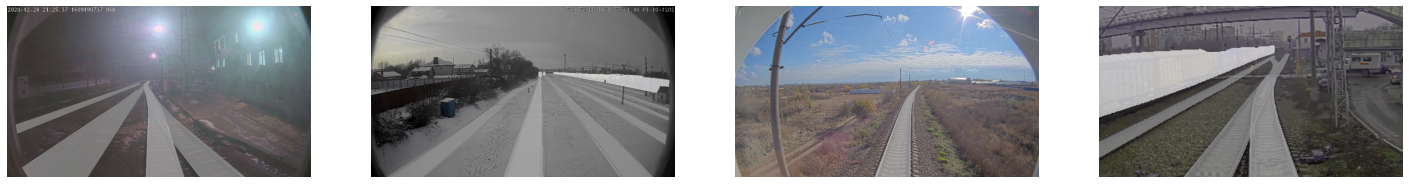

In [19]:
# Посмотрим несколько подготовленных картинок после аугментации
n = 4
fig, axs = plt.subplots(1, n, figsize=(25, 10))  

for i in range(n): 
  
  idx = random.randrange(len(images))
  
  image = (images_np[idx] * 255).astype(np.uint8)
  ann = ohe_to_mask(anns_np[idx]) * 25
    
  image[:, :, 0] = np.where(ann == 0, image[:, :, 0], image[:, :, 0] * 0.3 + ann*0.7)
  image[:, :, 1] = np.where(ann == 0, image[:, :, 1], image[:, :, 1] * 0.3 + ann*0.7)
  image[:, :, 2] = np.where(ann == 0, image[:, :, 2], image[:, :, 2] * 0.3 + ann*0.7)

  
  axs[i].axis('off')
  axs[i].imshow(image)             

plt.show()   